In [1]:
%load_ext autoreload
%autoreload 2

import pprint
from typing import OrderedDict

import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision.datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

import models.resnet
import models.resnet_dropout
import models.unet_model
import utils.detection_metrics
import utils.metrics
import utils.model
import utils.visualisations
from utils.temperature_scaling import ModelWithTemperature

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

VOC_DICT = {cls: i for i, cls in enumerate(VOC_CLASSES)}


class VOCTransform(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, label):
        annotation = label["annotation"]
        id = int(annotation["filename"].replace(".jpg", "").replace("_", ""))
        out = {
            "boxes": [],
            "labels": [],
            "image_id": torch.tensor(id, dtype=torch.int64),
            "area": [],
            "iscrowd": []
        }
        for obj in annotation["object"]:
            box_dict = obj["bndbox"]
            box = [float(box_dict["xmin"]), float(box_dict["ymin"]),
                   float(box_dict["xmax"]), float(box_dict["ymax"])]
            out["boxes"].append(box)
            out["labels"].append(VOC_DICT[obj["name"]])
            out["area"].append((box[2]-box[0]) * (box[3] - box[1]))
            out["iscrowd"].append(0)
        out["boxes"] = torch.as_tensor(out["boxes"], dtype=torch.float)
        out["labels"] = torch.as_tensor(out["labels"], dtype=torch.int64)
        out["area"] = torch.as_tensor(out["area"], dtype=torch.float)
        out["iscrowd"] = torch.as_tensor(out["iscrowd"], dtype=torch.uint8)
        return out


def collate_fn(batch):
    return list(zip(*batch))


transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip()
])


target_transforms = torchvision.transforms.Compose([
    VOCTransform()
])


data_train = torchvision.datasets.VOCDetection(
    root="VOC", download=True, image_set="train", transform=transforms_train, target_transform=VOCTransform())
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=16,
                                                shuffle=True,
                                                collate_fn=collate_fn)


data_test = torchvision.datasets.VOCDetection(
    root="VOC", download=True, image_set="val", transform=torchvision.transforms.ToTensor(), target_transform=VOCTransform())
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=16,
                                               shuffle=False,
                                               collate_fn=collate_fn)

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


In [132]:
# model = models.unet_model.UNet(3, 21).to(device)
model = torch.load("checkpoints/faster_rcnn_box_predictor_dropout0.2.pt")

In [133]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [10]:
def bbox_dict_to_tensor(pred: dict):
    if "scores" not in pred:
        pred["scores"] = torch.ones_like(pred["labels"])
    return torch.cat((pred["labels"].unsqueeze(1), pred["scores"].unsqueeze(
        1), pred["boxes"]), 1).tolist()


def validate_model(model, data_loader, device):
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []
    train_idx = 0
    progress_bar = tqdm(data_loader)
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()}
                    for t in targets]

        with torch.no_grad():
            out = model(images)
        for idx, pred in enumerate(out):
            bboxes = bbox_dict_to_tensor(pred)
            true_bboxes = bbox_dict_to_tensor(targets[idx])
            nms_boxes = utils.detection_metrics.nms(
                bboxes,
                iou_threshold=0.5,
                threshold=0,
                box_format="corners",
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes:
                # many will get converted to 0 pred
                # if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)
            train_idx += 1

    AP_50 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.5, box_format="corners", num_classes=21)
    AP_75 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.75, box_format="corners", num_classes=21)
    print(f'AP 50: {AP_50:.2f} AP 75: {AP_75:.2f}')
    return all_pred_boxes, all_true_boxes


pred_boxes, true_boxes = validate_model(
    model,  data_loader_test, device)

100%|██████████| 364/364 [03:52<00:00,  1.56it/s]


AP 50: 0.74 AP 75: 0.48


In [7]:
import matplotlib.patches as patches

def plot_image(image, boxes, gt_boxes):
    """Plots predicted bounding boxes on the image"""
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1,2,0))
    im = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        cls = box[1]
        confidence = box[2]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5*confidence,
            edgecolor="r",
            facecolor="none"
        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="r")
        # Add the patch to the Axes
        ax.add_patch(rect)

    for box in gt_boxes:
        cls = box[1]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=1,
            edgecolor="g",
            facecolor="none"

        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="g")

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [8]:
def correct_boxes(preds, gt, num_classes, iou_threshold=0.5):
    max_idx = gt[-1][0]
    TP = torch.zeros((max_idx + 1, num_classes))
    FP = torch.zeros_like(TP)
    FN = torch.zeros_like(TP)
    for img_idx in range(max_idx + 1):
        pred_boxes = sorted(list(filter(lambda box: box[0]==img_idx, preds)), key=lambda box: box[2], reverse=True)
        true_boxes = list(filter(lambda box: box[0]==img_idx, gt))
        for i,true_box in enumerate(true_boxes[:]):
            for j,pred_box in enumerate(pred_boxes[:]):
                if(true_box[1] == pred_box[1] and 
                utils.detection_metrics.intersection_over_union(
                    torch.tensor(pred_box[3:]), 
                    torch.tensor(true_box[3:]), 
                    box_format="corners") > iou_threshold):
                    TP[img_idx][int(true_box[1])] += 1
                
                    true_boxes.pop(i)
                    pred_boxes.pop(j)
        for box in pred_boxes:
            FP[img_idx][int(box[1])] += 1
        for box in true_boxes:
            FN[img_idx][int(box[1])] += 1
    return TP, FP, FN


def correct_boxes(preds, gt, num_classes, iou_threshold=0.5):
    max_idx = gt[-1][0]
    TP = []
    FP = []
    FN = []
    for img_idx in range(max_idx + 1):
        pred_boxes = sorted(list(filter(lambda box: box[0]==img_idx, preds)), key=lambda box: box[2], reverse=True)
        true_boxes = list(filter(lambda box: box[0]==img_idx, gt))
        for pred_box_idx,pred_box in enumerate(pred_boxes[:]):
            best_iou = 0
            best_iou_idx = None
            for true_box_idx,true_box in enumerate(true_boxes):
                if true_box[1] == pred_box[1]:  
                    iou = utils.detection_metrics.intersection_over_union(
                        torch.tensor(pred_box[3:]), 
                        torch.tensor(true_box[3:]), 
                        box_format="corners")
                    if iou > best_iou:
                        best_iou = iou
                        best_iou_idx = true_box_idx
            if best_iou > iou_threshold:
                TP.append(pred_box)
                true_boxes.remove(true_boxes[best_iou_idx])
                pred_boxes.remove(pred_box)
                   
        for box in pred_boxes:
            FP.append(box)
        for box in true_boxes:
            FN.append(box)
    return TP, FP, FN

In [27]:
preds[0]

[[2545,
  18.0,
  0.9310223460197449,
  209.9874267578125,
  152.3942413330078,
  308.5556335449219,
  233.34213256835938],
 [2545,
  9.0,
  0.8138048648834229,
  313.9580383300781,
  171.69436645507812,
  402.24114990234375,
  250.81256103515625],
 [2545,
  9.0,
  0.7597856521606445,
  210.0852508544922,
  189.58152770996094,
  287.8028259277344,
  270.8863220214844],
 [2545,
  16.0,
  0.7356467843055725,
  116.75482177734375,
  119.02970886230469,
  176.88438415527344,
  183.45181274414062],
 [2545,
  9.0,
  0.7334302067756653,
  97.3152084350586,
  175.25685119628906,
  182.91566467285156,
  256.02520751953125],
 [2545,
  16.0,
  0.71909099817276,
  150.65313720703125,
  129.49508666992188,
  229.12510681152344,
  229.4721221923828],
 [2545,
  16.0,
  0.6893900036811829,
  339.3027648925781,
  104.18438720703125,
  379.0115966796875,
  167.3781280517578],
 [2545,
  18.0,
  0.6286737322807312,
  326.084716796875,
  164.79638671875,
  410.658447265625,
  262.2406921386719],
 [2545,
  

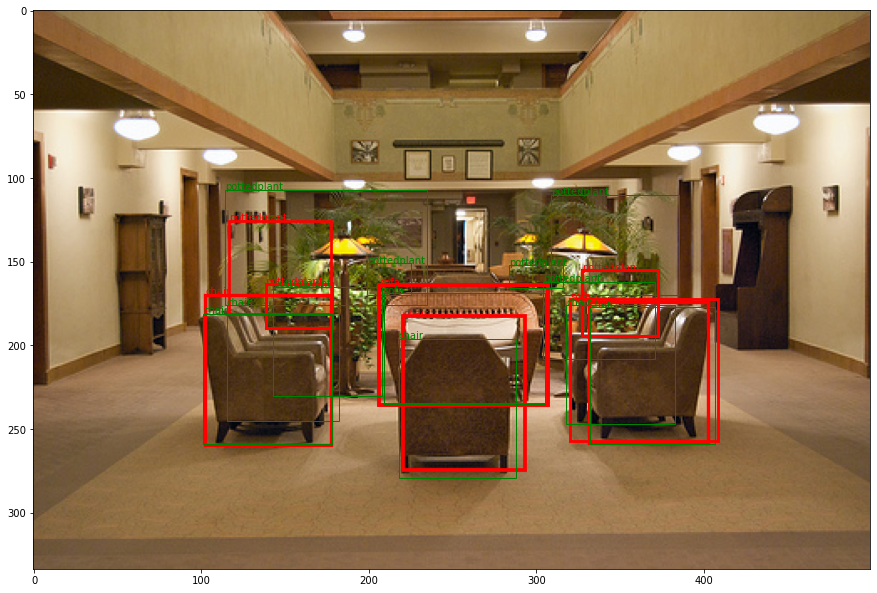

In [157]:
import random
utils.mc_dropout.set_training_mode_for_dropout(model, True)
# i = random.randint(0, len(data_test))
i=2545
preds = []
for _ in range(20):
    pred = bbox_dict_to_tensor(model(data_test[i][0].unsqueeze(0).to(device))[0])
    pred = utils.detection_metrics.nms(pred, 0.5, 0.5, "corners")
    preds.append(list(map(lambda box: [i] + box, pred)))
gt = list(filter(lambda box: box[0]==i, true_boxes))
plot_image(data_test[i][0], preds[0], gt)

In [69]:
class Observation:
    def __init__(self,bbox):
        self.bboxes= [bbox]
        self.mean = bbox
        self.prediction = bbox[1]
    
    def append(self, bbox):
        self.bboxes.append(bbox)
        self.mean = np.mean(self.bboxes, axis=0).tolist()

    def should_be_grouped(self, bbox, iou_threshold=0.95):
        if int(self.prediction) != int(bbox[1]):
            return False
        if utils.detection_metrics.intersection_over_union(torch.tensor(self.mean[3:]), torch.tensor(bbox[3:])) > iou_threshold:
            return True
        return False

    def __repr__(self):
        return f"{self.mean}, {len(self.bboxes)} bboxes combined"



        
        

In [48]:
preds[0][0],preds[1][0]

([2545,
  18.0,
  0.9310223460197449,
  209.9874267578125,
  152.3942413330078,
  308.5556335449219,
  233.34213256835938],
 [2545,
  18.0,
  0.752103328704834,
  214.66517639160156,
  158.68765258789062,
  312.5939025878906,
  238.76608276367188])

In [175]:
def combine_boxes(preds):
    observations = []
    for i in preds:
        for bbox in i:
            grouped = False
            for observation in observations:
                if observation.should_be_grouped(bbox, iou_threshold=0.95):
                    observation.append(bbox)
                    grouped = True
                    break
            if not grouped:
                observations.append(Observation(bbox))
    return observations

combined = combine_boxes(preds)
        

In [179]:
combined_boxes = [box.mean for box in combined if box.mean[2] > .0 and len(box.bboxes) >= 10]

In [180]:
combined

[[2545.0, 18.0, 0.7907412383291457, 208.78304206000433, 163.27618662516275, 309.7829878065321, 236.16292232937283], 18 bboxes combined,
 [2545.0, 9.0, 0.6469690799713135, 219.9234535217285, 180.7207344055176, 291.6807693481445, 274.20208129882815], 20 bboxes combined,
 [2545.0, 9.0, 0.6824268348076764, 329.272902544807, 169.28854639389937, 403.8654085047105, 258.08900720932905], 17 bboxes combined,
 [2545.0, 9.0, 0.706149246957567, 103.33260515001085, 169.01627434624567, 179.1262681749132, 260.93546888563367], 9 bboxes combined,
 [2545.0, 16.0, 0.5987369894981385, 326.9172709147135, 157.04981384277343, 370.54856363932294, 194.25946146647135], 15 bboxes combined,
 [2545.0, 16.0, 0.600456964969635, 138.21630477905273, 162.72149887084962, 176.06670150756835, 190.09430541992188], 20 bboxes combined,
 [2545.0, 18.0, 0.5768574178218842, 320.61478000217016, 174.70047420925565, 410.3084530300564, 256.33854505750867], 18 bboxes combined,
 [2545.0, 16.0, 0.6306302882730961, 117.02509880065918, 1

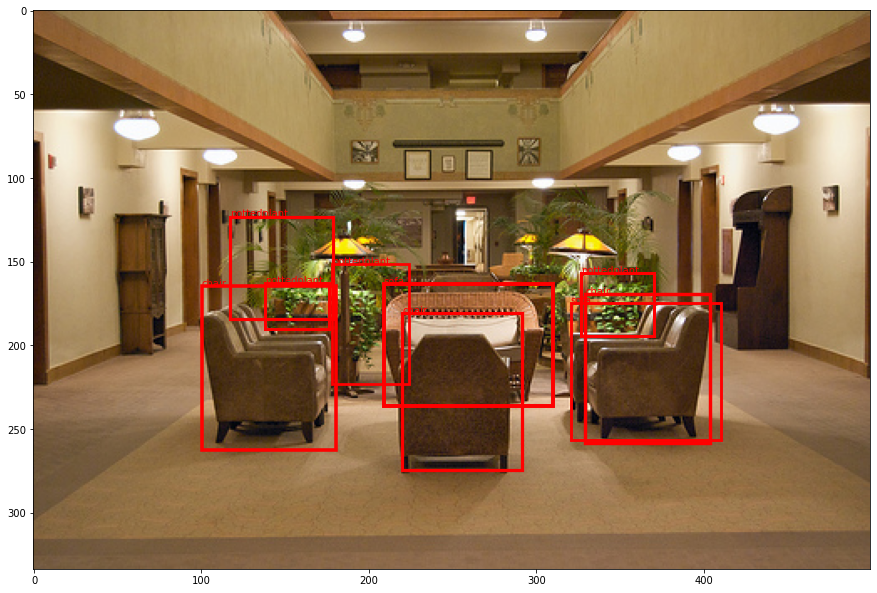

In [181]:
plot_image(data_test[i][0], combined_boxes, [])

In [325]:
utils.detection_metrics.mean_average_precision(pred_boxes, true_boxes, 0.5, "corners", 21)

tensor(0.6406)

In [326]:
TP, FP, FN = correct_boxes(pred_boxes, true_boxes, len(VOC_CLASSES))


In [327]:
correct = [1]*len(TP) + [0]*len(FP)
probs = [box[2]  for box in TP+FP]
curves =[utils.metrics.compute_model_stats(correct, probs, "test")]

In [331]:
len(TP)*2+ len(FP)+ len(FN), len(pred_boxes) + len(true_boxes)

(30694, 30694)

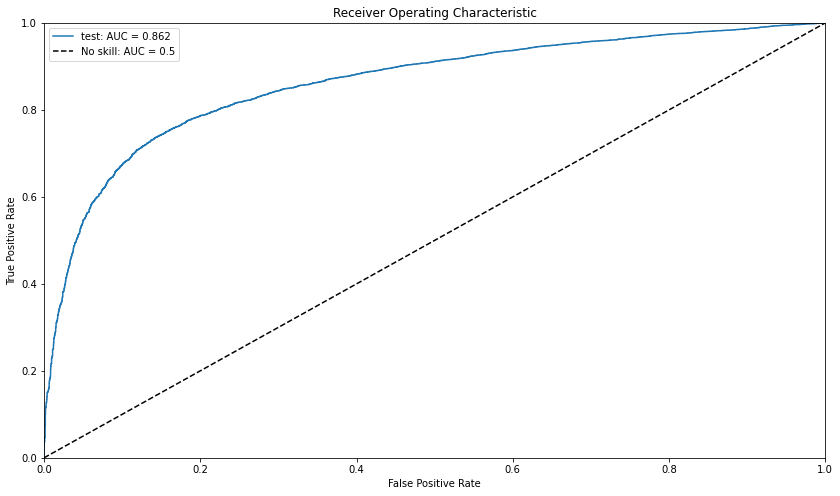

In [328]:
plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

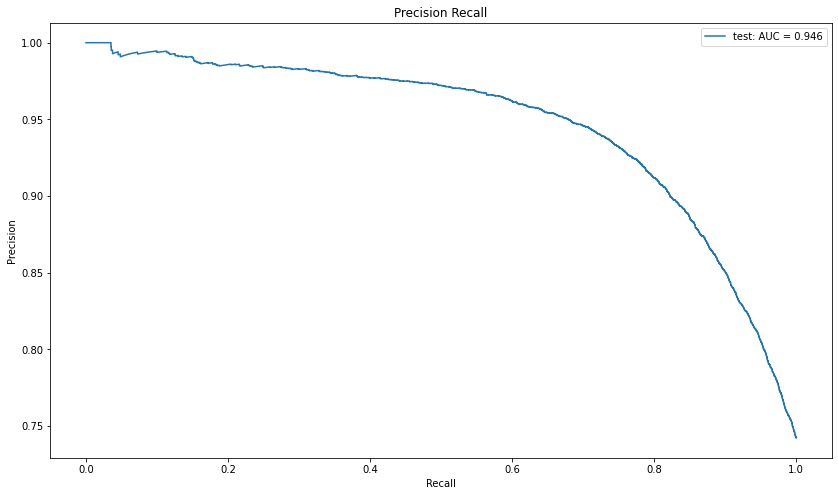

In [329]:
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()